# Приоретизация и проверка гипотез для увеличения выручки интернет-магазина.

<a id="back"></a>
### Содержание 

- #### [0. Постановка задач.](#step_0)
- #### [1. Изучение данных из файлов.](#step_1)
- #### [2. Часть 1. Приоритизация гипотез.](#step_2)
- #### [3. Часть 2. Анализ A/B-теста.](#step_3)
- #### [4. Выводы.](#step_4)

<a id="step_0"></a>
## 0= Контекст / постановка задачи.

[к оглавлению](#back)

Роль в проекте — аналитик крупного интернет-магазина. Вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

<a id="step_1"></a>
## 1= Изучение данных из файлов

[к оглавлению](#back)

### Импорт библиотек.

In [1]:
import pandas as pd
import os
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas.plotting import register_matplotlib_converters
import re
import datetime as dt
import warnings
import scipy.stats as stats


# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

### Настройка формата чисел и т.п.

In [2]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', 0)

### Импорт данных и общая информация.

|имя файла              |id |link |
|-----------------------|---|-----|
|hypothesis.csv|15uytPA0pqqlvmPs8KallGF1UNqY6I[...]|https://drive.google.com/file/d/15uytPA0pqqlvmPs8KallGF1UNqY6I[...]/view?usp=sharing|
|orders.csv.csv|139kphspoPrlODh7JL7tfIyYM267Ey[...]|https://drive.google.com/file/d/139kphspoPrlODh7JL7tfIyYM267Ey[...]/view?usp=sharing|
|visitors.csv|1aK5LJS7BW8ZxwyA04-6vZcXgrAGeO[...]|https://drive.google.com/file/d/1aK5LJS7BW8ZxwyA04-6vZcXgrAGeOorb/view?usp=sharing|

Проект колаба сохранён здесь: https://colab.research.google.com/drive/19-oSqOfqDu8XZNhrLLFTRr7MuYljG[...]

In [3]:
print('Загружаем датасеты из google drive, если возможно:')

try:
    ! gdown 15uytPA0pqqlvmPs8KallGF1UNqY6I[...]
    ! gdown 139kphspoPrlODh7JL7tfIyYM267Ey[...]
    ! gdown 1aK5LJS7BW8ZxwyA04-6vZcXgrAGeO[...]
    #print('Датасеты загружены из Google Drive')
except:
    print('Датасеты из Google Drive загрузить НЕ удалось!')

Загружаем датасеты из google drive, если возможно:
/bin/bash: gdown: command not found
/bin/bash: gdown: command not found
/bin/bash: gdown: command not found


**Определяем переменные датасетов:**

Префиксы:

In [4]:
path_prefix_yandex = '/datasets/'
path_prefix_local = '../datasets/'
path_prefix_colab = '/content/'

hypothesis_name = 'hypothesis.csv'
orders_name = 'orders.csv'
visitors_name = 'visitors.csv'

hypothesis_y = path_prefix_yandex + hypothesis_name
hypothesis_l = path_prefix_local + hypothesis_name
hypothesis_c = path_prefix_colab + hypothesis_name

orders_y = path_prefix_yandex + orders_name
orders_l = path_prefix_local + orders_name
orders_c = path_prefix_colab + orders_name

visitors_y = path_prefix_yandex + visitors_name
visitors_l = path_prefix_local + visitors_name
visitors_c = path_prefix_colab + visitors_name


#++++++++++++++++++++++++++++++++++#
if os.path.exists(visitors_y):
    visits = pd.read_csv(visitors_y)
    orders = pd.read_csv(orders_y)
    hypothesis  = pd.read_csv(hypothesis_y)
    print('Загружены данные с сервера Яндекс.Практикума.')
elif os.path.exists(visitors_l):
    visits = pd.read_csv(visitors_l)
    orders = pd.read_csv(orders_l)
    hypothesis  = pd.read_csv(hypothesis_l)
    print('Загружены данные с локального сервера.')
elif os.path.exists(visitors_c):
    visits = pd.read_csv(visitors_c)
    orders = pd.read_csv(orders_c)
    hypothesis  = pd.read_csv(hypothesis_c)
    print('Загружены данные с сервера Google Colab.')
else:
    print('Что-то пошло не так... Проверь названия и пути импортируемых файлов.')

Загружены данные с сервера Яндекс.Практикума.


Проверим, что в датасетах:

In [5]:
display(visits.head(5))
display(orders.head(5))
display(hypothesis.head(5))

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [6]:
print('visits.info()')
display(visits.info())
print('\norders.info()')
display(orders.info())
print('\nhypothesis.info()')
display(hypothesis.info())

visits.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None


orders.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None


hypothesis.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Посчитаем общее количество визитов за всё время:

In [7]:
visits.groupby('group').agg({'visitors' : 'sum'})

,visitors
group,
A,18736
B,18916


Посчитаем общее количество заказов за всё время:

In [8]:
orders.groupby('group').agg({'transactionId' : 'count'})

,transactionId
group,
A,557
B,640


In [9]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [10]:
#orders.pivot_table(index='visitorId', values='group', aggfunc='nunique')

**Посчитаем, сколько пользователей вошло в группы А и В.**

Для начала для группы А:

In [11]:
orders[orders['group'] == 'A']['visitorId'].nunique()

503

In [12]:
orders[orders['group'] == 'A']['visitorId'].duplicated().sum()

54

Получилось 503 уникальных пользователя, которые совершили хотя бы одну покупку. И 54, которые совершили 2 или более покупок.

Посчитаем теперь, сколько их вошло в группу В:

In [13]:
orders[orders['group'] == 'B']['visitorId'].nunique()

586

In [14]:
orders[orders['group'] == 'B']['visitorId'].duplicated().sum()

54

Получилось 586 уникальных пользователей, которые совершили хотя бы одну покупку. И 54, которые совершили 2 или более покупок.

**Посчитаем, пересекаются ли группы А и В по пользователям:**

Посчитаем, сколько заказов из группы А сделали пользователи, которые сделали заказы из группы В?

In [15]:
orders['duplicatedAB'] = orders[orders['group'] == 'A']['visitorId'].isin(orders[orders['group'] == 'B']['visitorId'])
orders

,transactionId,visitorId,date,revenue,group,duplicatedAB
0,3667963787,3312258926,2019-08-15,1650,B,NaN
1,2804400009,3642806036,2019-08-15,730,B,NaN
2,2961555356,4069496402,2019-08-15,400,A,True
3,3797467345,1196621759,2019-08-15,9759,B,NaN
4,2282983706,2322279887,2019-08-15,2308,B,NaN
...,...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B,NaN
1193,2203539145,370388673,2019-08-14,3190,A,False
1194,1807773912,573423106,2019-08-14,10550,A,False
1195,1947021204,1614305549,2019-08-14,100,A,True


Посчитаем, сколько заказов из группы В сделали пользователи, которые сделали заказы из группы А?

In [16]:
orders['duplicatedBA'] = orders[orders['group'] == 'B']['visitorId'].isin(orders[orders['group'] == 'A']['visitorId'])
orders

,transactionId,visitorId,date,revenue,group,duplicatedAB,duplicatedBA
0,3667963787,3312258926,2019-08-15,1650,B,NaN,False
1,2804400009,3642806036,2019-08-15,730,B,NaN,False
2,2961555356,4069496402,2019-08-15,400,A,True,NaN
3,3797467345,1196621759,2019-08-15,9759,B,NaN,False
4,2282983706,2322279887,2019-08-15,2308,B,NaN,False
...,...,...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B,NaN,False
1193,2203539145,370388673,2019-08-14,3190,A,False,NaN
1194,1807773912,573423106,2019-08-14,10550,A,False,NaN
1195,1947021204,1614305549,2019-08-14,100,A,True,NaN


А теперь сведём их в один список в колонке duplicated:

In [17]:
orders[['duplicatedAB', 'duplicatedBA']] = orders[['duplicatedAB', 'duplicatedBA']].fillna(False)
orders

,transactionId,visitorId,date,revenue,group,duplicatedAB,duplicatedBA
0,3667963787,3312258926,2019-08-15,1650,B,False,False
1,2804400009,3642806036,2019-08-15,730,B,False,False
2,2961555356,4069496402,2019-08-15,400,A,True,False
3,3797467345,1196621759,2019-08-15,9759,B,False,False
4,2282983706,2322279887,2019-08-15,2308,B,False,False
...,...,...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B,False,False
1193,2203539145,370388673,2019-08-14,3190,A,False,False
1194,1807773912,573423106,2019-08-14,10550,A,False,False
1195,1947021204,1614305549,2019-08-14,100,A,True,False


In [18]:
orders['duplicated'] = orders['duplicatedAB'] | orders['duplicatedBA'] 
orders

,transactionId,visitorId,date,revenue,group,duplicatedAB,duplicatedBA,duplicated
0,3667963787,3312258926,2019-08-15,1650,B,False,False,False
1,2804400009,3642806036,2019-08-15,730,B,False,False,False
2,2961555356,4069496402,2019-08-15,400,A,True,False,True
3,3797467345,1196621759,2019-08-15,9759,B,False,False,False
4,2282983706,2322279887,2019-08-15,2308,B,False,False,False
...,...,...,...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B,False,False,False
1193,2203539145,370388673,2019-08-14,3190,A,False,False,False
1194,1807773912,573423106,2019-08-14,10550,A,False,False,False
1195,1947021204,1614305549,2019-08-14,100,A,True,False,True


Посчитаем, сколько всего заказов от пользователей, которые засветились в двух группах:

In [19]:
orders['duplicated'].sum()

181

А теперь посмотрим, сколько это пользователей делали такие заказы:

In [20]:
orders[orders['duplicated'] == True]['visitorId'].nunique()

58

Удалим из датасета `orders` заказы, которые делали пользователи, которые попали в обе группы. 

In [21]:
orders = orders.drop(orders[orders['duplicated'] == True].index)
orders

,transactionId,visitorId,date,revenue,group,duplicatedAB,duplicatedBA,duplicated
0,3667963787,3312258926,2019-08-15,1650,B,False,False,False
1,2804400009,3642806036,2019-08-15,730,B,False,False,False
3,3797467345,1196621759,2019-08-15,9759,B,False,False,False
4,2282983706,2322279887,2019-08-15,2308,B,False,False,False
5,182168103,935554773,2019-08-15,2210,B,False,False,False
...,...,...,...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B,False,False,False
1192,2662137336,3733762160,2019-08-14,6490,B,False,False,False
1193,2203539145,370388673,2019-08-14,3190,A,False,False,False
1194,1807773912,573423106,2019-08-14,10550,A,False,False,False


Теперь проверим, насколко сократилась каждая из групп:

In [22]:
orders.groupby('group').agg({'transactionId' : 'count'})

,transactionId
group,
A,468
B,548


Таким образом группа А уменьшилась с 557 до **468** визитёров-покупателей, а группа В с 640 до **548**.

Тем не менее этого достаточно для того, чтобы провести А/В тест.

#### Проверяем имена.

- Таблица `hypothesis`:
 - нужно привести к `camel_case`


- Таблица `visits`:
 - нужно привести к `camel_case`

- Таблица `orders`: ok



In [23]:
hypothesis.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', x).lower() for x in hypothesis.columns.values]
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [24]:
orders.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', x).lower() for x in orders.columns.values]
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group',
       'duplicated_a_b', 'duplicated_b_a', 'duplicated'],
      dtype='object')

#### Проверяем пропуски.

- Таблица `hypothesis`: ok


- Таблица `visits`: ok


- Таблица `orders`: ok



#### Проверяем типы данных.
- Таблица `hypothesis`: ok


- Таблица `visits`:
 - `date` нужно изменить с `object` на `datetime`

- Таблица `orders`:
 - `date` нужно изменить с `object` на `datetime`


In [25]:
visits['date'] = pd.to_datetime(visits['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [26]:
display(visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

In [27]:
display(orders.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
 5   duplicated_a_b  1016 non-null   bool          
 6   duplicated_b_a  1016 non-null   bool          
 7   duplicated      1016 non-null   bool          
dtypes: bool(3), datetime64[ns](1), int64(3), object(1)
memory usage: 50.6+ KB


None

#### Проверяем дубликаты.

In [28]:
visits.duplicated().sum()

0

In [29]:
orders.duplicated().sum()

0

In [30]:
hypothesis.duplicated().sum()

0

- Таблица `hypothesis`: ok


- Таблица `visits`: ok


- Таблица `orders`: ok



### Выводы по разделу:

- датасеты содержат информацию о 18736 визитах из группы А и 18916 визитах из группы B, а также 468 заказов в группе А и 548 заказах в группе В. Этого, похоже, достаточно для проведения исследования.
- при этом из анализа удалили данные о 181 заказе от 58 пользователей, которые попали в группы A и В одновременно. Они были удалены из таблицы.
- имена в `hypothesis` и `visits` приведены к `camel_case`
- Пропусков нет ни в одном из датасетов.
- Проверяем типы данных - изменили тип со строковрого на дату в датасетах `visits` и `orders`.
- дубликатов в входных данных нет ни в одном из датасетов.

<a id="step_2"></a>
## 2 = Часть 1. Приоритизация гипотез.

[к оглавлению](#back)

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.



### Описание данных. Данные для первой части
Файл /datasets/hypothesis.csv. [Скачать датасет](http://fd.tu)
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.



**Задачи:**
* Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.


### Cчитаем ICE.
*Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.*

In [31]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='ICE', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


### Cчитаем RICE.
Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.


In [32]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='RICE', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


### Cравниваем ICE и RICE.
*Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.*

Как RICE изменил приоритеты в этом датасете:
* увеличились приоритеты:
 * #7 (3 => 1) "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
 * #2 (5 => 2) "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"

* уменьшились приоритеты:
 * #8 (1 => 5) "Запустить акцию, дающую скидку на товар в день рождения"
 * #0 (2 => 3) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

RICE отличается от ICE параметром Reach, т.е. охватом аудитории. Этот параметр важен, т.к. в А/B тестировании важно колчество испытуемых, поэтому RICE для AB-тестирования выглядит более интересным, чем ICE.

### Выводы по разделу:

Поскольку для интернет магазина вероятно значимым является охват, то отдаём приоритет гипотезам:
* 7	Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* 2	Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* 0	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

<a id="step_3"></a>
## 3 = Часть 2. Анализ A/B-теста.
[к оглавлению](#back)



### Описание данных. Данные для второй части
Файл /datasets/orders.csv. Скачать датасет
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. Скачать датасет
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

**Задача для части 2: Проанализируйте A/B-тест**
* Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
* Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
* Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
* Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.
* Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.
* Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
* Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
* Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
* Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
* Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.
* Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
* Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.
* Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
Примите решение по результатам теста и объясните его. Варианты решений: 
 * 1. Остановить тест, зафиксировать победу одной из групп. 
 * 2. Остановить тест, зафиксировать отсутствие различий между группами. 
 * 3. Продолжить тест.

### Подготовка данных к анализу.

Готовим таблицу, к которой будем присоединять данные в формате дата-группа.

In [33]:
datesGroups = orders[['date', 'group']].drop_duplicates().sort_values(by=['date', 'group'])
datesGroups

,date,group
55,2019-08-01,A
66,2019-08-01,B
175,2019-08-02,A
173,2019-08-02,B
291,2019-08-03,A
...,...,...
533,2019-08-29,B
757,2019-08-30,A
690,2019-08-30,B
958,2019-08-31,A


In [34]:
orders

,transaction_id,visitor_id,date,revenue,group,duplicated_a_b,duplicated_b_a,duplicated
0,3667963787,3312258926,2019-08-15,1650,B,False,False,False
1,2804400009,3642806036,2019-08-15,730,B,False,False,False
3,3797467345,1196621759,2019-08-15,9759,B,False,False,False
4,2282983706,2322279887,2019-08-15,2308,B,False,False,False
5,182168103,935554773,2019-08-15,2210,B,False,False,False
...,...,...,...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B,False,False,False
1192,2662137336,3733762160,2019-08-14,6490,B,False,False,False
1193,2203539145,370388673,2019-08-14,3190,A,False,False,False
1194,1807773912,573423106,2019-08-14,10550,A,False,False,False


Присоединяем к таблице "дата х группа" сагрегированные данные по заказам.

In [35]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({
        'date' : 'max', 
        'group' : 'max', 
        'transaction_id' : 'nunique', 
        'visitor_id' : 'nunique', 
        'revenue' : 'sum'
        }), axis=1
).sort_values(by=['date','group']) 
ordersAggregated

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854
...,...,...,...,...,...
533,2019-08-29,B,510,490,4746610
757,2019-08-30,A,460,437,3311413
690,2019-08-30,B,531,511,4955833
958,2019-08-31,A,468,445,3364656


Присоединяем к таблице "дата х группа х заказы" саггрегированные данные по посетителям.

In [36]:
visitorsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(visits['date'] <= x['date'], 
                       visits['group'] == x['group'])]
    .agg({
        'date' : 'max', 
        'group' : 'max', 
        'visitors' : 'sum'
    }), axis=1).sort_values(by=['date','group']) 

visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


Собираем данные в одну таблицу для дальнейшего анализа:

In [37]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulativeData.columns = [
    'date', 
    'group', 
    'orders', 
    'buyers', 
    'revenue', 
    'visitors'
]

cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


### Кумулятивная выручка по группам.
*Постройте график кумулятивной выручки по группам.* 


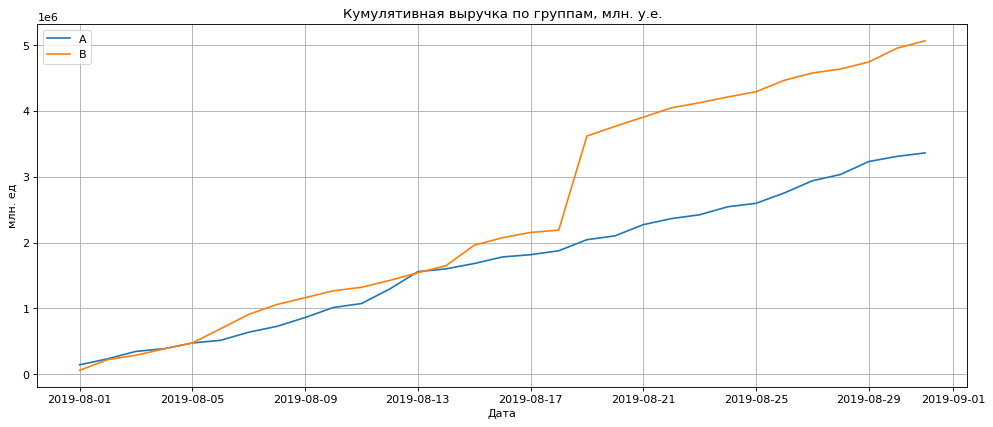

In [38]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

figure(figsize=(15, 6), dpi=80)

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.grid() 
plt.legend() 
plt.title('Кумулятивная выручка по группам, млн. у.е.')
plt.xlabel('Дата')
plt.ylabel('млн. ед')
plt.show() 

*Сделайте выводы и предположения.*

- графики выручки относительно равномерно растут, как и должно быть для нормального процесса продаж. 
- для группы В в районе 18-19 августа есть выброс, когда выручка резко увеличилась почти на миллион за один день. Вероятно, это был один или несколько очень дорогих заказов. Прверим это дальше.
- говорить о различии в выручке здесь нельзя из-за выброса. Для этого нужно продложить исследование.  

### Кумулятивный средний чек по группам.

*Постройте график кумулятивного среднего чека по группам.* 


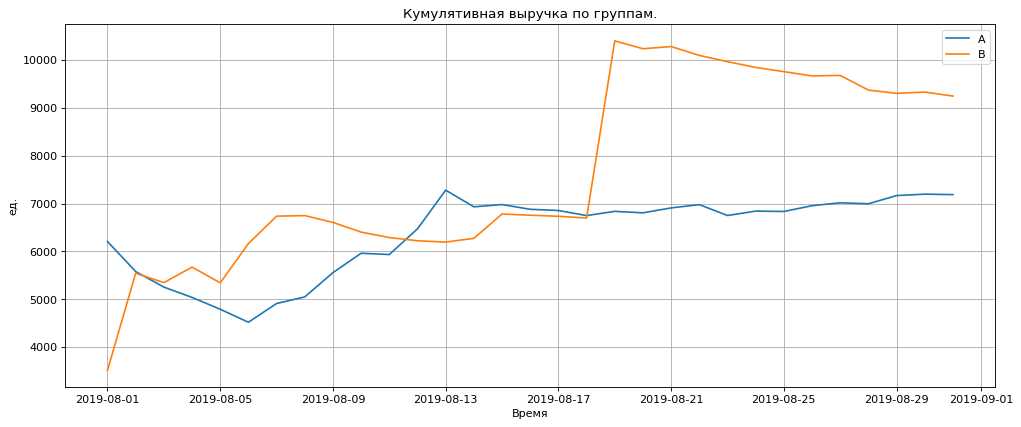

In [39]:
figure(figsize=(15, 6), dpi=80)

plt.plot(
    cumulativeRevenueA['date'], 
    cumulativeRevenueA['revenue']/
    cumulativeRevenueA['orders'], 
    label='A')
plt.plot(
    cumulativeRevenueB['date'], 
    cumulativeRevenueB['revenue']/
    cumulativeRevenueB['orders'], 
    label='B')

plt.grid() 
plt.legend() 
plt.title('Кумулятивная выручка по группам.')
plt.xlabel('Время')
plt.ylabel('ед.')
plt.show() 

*Сделайте выводы и предположения.*


- первые несколько дней средний чек достаточно сильно штормит, после чего они выравниваются, потом происходит выброс 18-19 августа для среднего чека группы В, 
- к концу теста средний чек группы А растёт, а группы В - падает, поэтому сказать, что из них лучше по этому графику нельзя. Нужно исследовать дальше. 

<div class="alert alert-success">
    <b>✅ Комментарий ревьюера:</b>

Все верно, средний чек группы В еще не стабилизировался.
</div>

### Относительное изменение кумулятивного среднего чека группы B к группе A.

*Постройте график относительного изменения кумулятивного среднего чека группы B к группе A.*

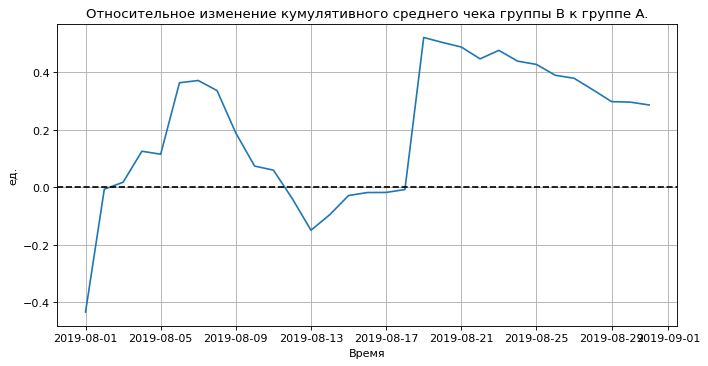

In [40]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
    )

def cum_avg_revenue_per_user():
    figure(figsize=(10, 5), dpi=80)
    
    # cтроим отношение средних чеков
    plt.plot(mergedCumulativeRevenue['date'], 
            (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
            /
            (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])
            -1
            )

    # добавляем ось X
    plt.axhline(y=0, color='black', linestyle='--')

    plt.grid() 
    plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A.')
    plt.xlabel('Время')
    plt.ylabel('ед.')
    plt.show() 

    return True

cum_avg_revenue_per_user()
None

*Сделайте выводы и предположения.*

- как и по предыдущему графику делать выводы нельзя из-за выбросов. Есть подозрение, что отношение кумулятивных конверсий оказжется ниже после того, как убрать выбросы.

### Кумулятивная конверсия (сумма количества заказов на сумму количества посетителей) по группам.


*Постройте график кумулятивной конверсии по группам.*

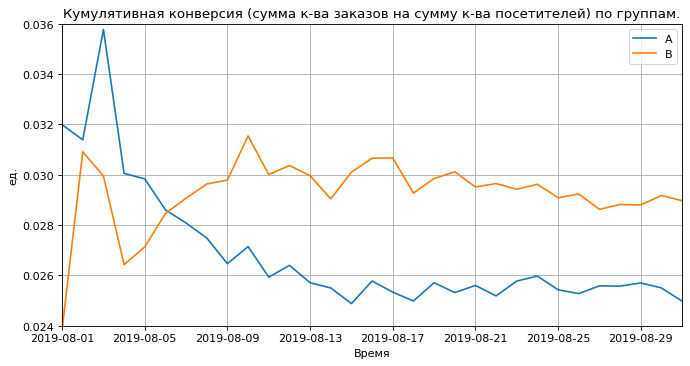

In [41]:
figure(figsize=(10, 5), dpi=80)

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.024, 0.036])

plt.grid() 
plt.legend() 
plt.title('Кумулятивная конверсия (сумма к-ва заказов на сумму к-ва посетителей) по группам.')
plt.xlabel('Время')
plt.ylabel('ед.')
plt.show() 

In [42]:
cumulativeDataA

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.03
2,2019-08-02,A,42,36,234381,1338,0.03
4,2019-08-03,A,66,60,346854,1845,0.04
6,2019-08-04,A,77,71,388030,2562,0.03
8,2019-08-05,A,99,92,474413,3318,0.03
10,2019-08-06,A,114,104,515332,3985,0.03
12,2019-08-07,A,130,120,638580,4629,0.03
14,2019-08-08,A,144,133,727219,5239,0.03
16,2019-08-09,A,155,143,861456,5856,0.03
18,2019-08-10,A,170,158,1013731,6262,0.03


*Сделайте выводы и предположения.*


В середине августа значения конверсии (из визитов в заказы) устаканились, и  в группе B значение стабильно выше. 

Это говорит о том, что:
- а) выбросы по количеству заказов ИЛИ количеству посетителей если и есть то они не так заметны, как в случае с выручкой и средним чеком.
- б) конверсия из визитов в заказы стабильно выше в группе В на порядка 3.5% в абсолютных цифрах.

### Относительное изменение кумулятивной конверсии группы B к группе A.

*Постройте график относительного изменения кумулятивной конверсии группы B к группе A.*

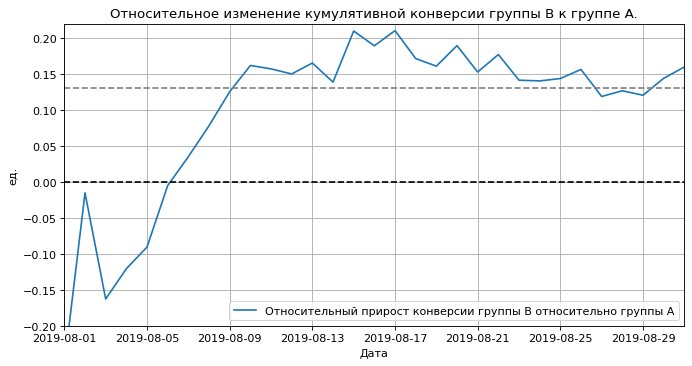

True

In [43]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
        cumulativeDataB[['date','conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['A', 'B']
        )

#print(mergedCumulativeConversions)

def cum_con():
    figure(figsize=(10, 5), dpi=80)
    
    plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
    plt.legend()

    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=0.13, color='grey', linestyle='--')
    plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.2, 0.22])

    plt.grid() 
    plt.legend() 
    plt.title('Относительное изменение кумулятивной конверсии группы B к группе A.')
    plt.xlabel('Дата')
    plt.ylabel('ед.')
    plt.show() 
    return True

cum_con()

*Сделайте выводы и предположения.*


- Этот график позволяет точнее оценить различия между группами.
- Конверсия из визитов в заказы стабильно выше в группе В на ~13% в относительных, что существенно.

### Точечный график количества заказов по пользователям.

*Постройте точечный график количества заказов по пользователям.*


        user_id  orders
908  3967698036  3     
55   249864742   3     
478  2108163459  3     
687  2988190573  3     
890  3908431265  3     
138  611059232   3     
632  2742574263  3     
157  678354126   2     
323  1404560065  2     
452  1985475298  2     


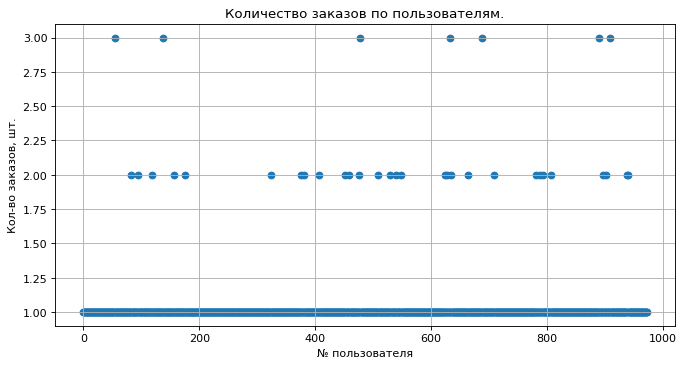

In [44]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['user_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

#ordersByUsers['orders'].hist()


# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

#print(x_values)
figure(figsize=(10, 5), dpi=80)
plt.scatter(x_values, ordersByUsers['orders']) 

plt.grid() 
plt.title('Количество заказов по пользователям.')
plt.xlabel('№ пользователя')
plt.ylabel('Кол-во заказов, шт.')
plt.show() 

*Сделайте выводы и предположения.*

Подавляющее большинство покупателей сделали по одному заказу. Точное количество определим, когда посчитаем перцентили ниже.


### 95-й и 99-й перцентили количества заказов на пользователя.

*Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.*

In [45]:
# Метод np.percentile('column', [percentile1, percentile2, percentile3]) находит перцентили.

print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 1. 2.]


In [46]:
orders_number_percentile = np.percentile(ordersByUsers['orders'], 95)
orders_number_percentile

1.0

95% всех покупателей сделали не более 2х заказов. Поэтому за границу определения аномальных пользователей возьмём все, что больше 2х покупок на человека.

### Точечный график стоимостей заказов.

In [47]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

#plt.hist(orders['revenue'], bins = 20)

      transaction_id  visitor_id       date  revenue group  duplicated_a_b  \
425   590470918       1920142716 2019-08-19  1294500  B     False            
1196  3936777065      2108080724 2019-08-15  202740   B     False            
1136  666610489       1307669133 2019-08-13  92550    A     False            
744   3668308183      888512513  2019-08-27  86620    B     False            
743   3603576309      4133034833 2019-08-09  67990    A     False            
1103  1348774318      1164614297 2019-08-12  66350    A     False            
1099  316924019       148427295  2019-08-12  65710    A     False            
949   1347999392      887908475  2019-08-21  60450    A     False            
940   2420050534      4003628586 2019-08-08  58550    B     False            
131   3163614039      2254586615 2019-08-22  53904    A     False            

      duplicated_b_a  duplicated  
425   False           False       
1196  False           False       
1136  False           False       
7

*Постройте точечный график стоимостей заказов*

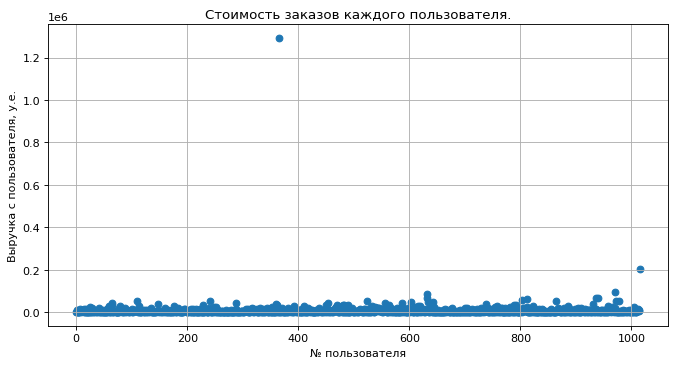

In [48]:
figure(figsize=(10, 5), dpi=80)
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.grid() 
plt.title('Стоимость заказов каждого пользователя.')
plt.xlabel('№ пользователя')
plt.ylabel('Выручка с пользователя, у.е.')
plt.show() 

Посмотрим более подробно на заказы менее 100к.

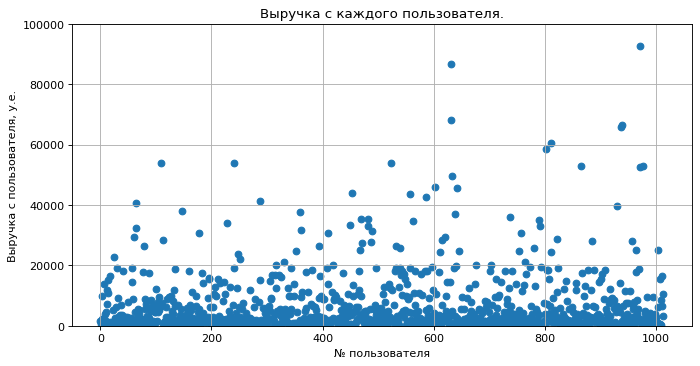

In [49]:
figure(figsize=(10, 5), dpi=80)
plt.ylim(0, 100000)
plt.scatter(x_values, orders['revenue'])

plt.grid() 
plt.title('Выручка с каждого пользователя.')
plt.xlabel('№ пользователя')
plt.ylabel('Выручка с пользователя, у.е.')
plt.show() 

*Сделайте выводы и предположения.*


Похоже, что найден виновник резкого всплеска 18-19 августа - кто-то один сделал заказ аж на 1.2 млн., при том, что остальные покупали не более, чем на 100 тыс.

Точные числа определим при рассчёте перцентилей ниже.

### 95-й и 99-й перцентили стоимости заказов.


*Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.*


In [50]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[17990. 26785. 53904.]


In [51]:
orders_price_percentile = np.percentile(orders['revenue'], 95)
orders_price_percentile

26785.0

Выберем 95% процентиль - аномальные заказы начинаются от 28000.

### Cтатистическая значимость различий в конверсии между группами по «сырым» данным.

*Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным.*

Для нахождения статистической значимости нужно получить два датасета, где отображалось бы:
- либо факт того, что пользователь совершил заказ (например, 1 для совершивших заказ или 0 для несовершивших), 
- количество покупок на одного пользователя (целое число).

Получим такой список:

In [52]:
orders

,transaction_id,visitor_id,date,revenue,group,duplicated_a_b,duplicated_b_a,duplicated
0,3667963787,3312258926,2019-08-15,1650,B,False,False,False
1,2804400009,3642806036,2019-08-15,730,B,False,False,False
3,3797467345,1196621759,2019-08-15,9759,B,False,False,False
4,2282983706,2322279887,2019-08-15,2308,B,False,False,False
5,182168103,935554773,2019-08-15,2210,B,False,False,False
...,...,...,...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B,False,False,False
1192,2662137336,3733762160,2019-08-14,6490,B,False,False,False
1193,2203539145,370388673,2019-08-14,3190,A,False,False,False
1194,1807773912,573423106,2019-08-14,10550,A,False,False,False


In [53]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.sort_values(by='transaction_id', ascending = False)


,visitor_id,transaction_id
58,611059232,3
211,2108163459,3
310,2988190573,3
409,3908431265,3
416,3967698036,3
...,...,...
146,1402025725,1
145,1398592185,1
144,1388079388,1
143,1378148355,1


Переименуем столбцы:

In [54]:
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersA

,userId,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1
...,...,...
440,4227830084,1
441,4237561104,1
442,4243832526,1
443,4259830713,1


и сделаем то же самое для для группы В:

In [55]:
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 
ordersByUsersB

,userId,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1
...,...,...
523,4251115836,1
524,4258103007,1
525,4279090005,1
526,4281247801,1


Для дальнейшей работы создадим большую таблицу, в которой были бы следующие столбцы:
- `date`  - дата
- `ordersPerDateA` - количество заказов в эту дату от покупателей из группы А
- `revenuePerDateA` - количество заказов в эту дату от покупателей из группы А
- `ordersPerDateB`  - количество заказов в эту дату от покупателей из группы В
- `revenuePerDateB` - количество заказов в эту дату от покупателей из группы В
- `visitorsPerDateA` - количество посетителей в эту дату из группы А
- `visitorsPerDateB` - количество посетителей в эту дату из группы В


In [56]:
visitorsADaily = visits[visits['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visits[visits['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01  23              142779           17               
1 2019-08-02  19              91602            23               
2 2019-08-03  24              112473           14               
3 2019-08-04  11              41176            14               
4 2019-08-05  22              86383            21               

   revenuePerDateB  visitorsPerDateA  visitorsPerDateB  
0  59758            719               713               
1  162043           619               581               
2  67049            507               509               
3  96890            717               770               
4  89908            756               707               


In [57]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(0, 
                index=np.arange(
                    data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), 
                name='orders'
                )
     ],
     axis=0)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0, 
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
                ), 
                name='orders'
                )
        ],
        axis=0) 

Создадим датасеты, которые бы подходили для решения задачи оценки статистической значимости.

In [58]:
sampleA.sort_values(ascending = False)

58       3
211      3
409      3
310      3
416      3
        ..
6100     0
6101     0
6102     0
6103     0
18290    0
Name: orders, Length: 18736, dtype: int64

In [59]:
sampleB.sort_values(ascending = False)

347      3
33       3
489      2
176      2
507      2
        ..
6133     0
6134     0
6135     0
6136     0
18387    0
Name: orders, Length: 18916, dtype: int64

А теперь можно оценить статистическую значимость, но для начала сформулируем гипотезу в явном виде:

**Сформулируем гипотезу о равенстве `конверсий из визитов в заказы в группах` А и В:**

**H0 (Нулевая гипотеза)** — конверсии из количества визитов к количество заказов в группе А и группе В равны
**H1 (Альтернативная гипотеза)** — конверсии группы А и группы В не равны.
**Уровень alpha** (уровень критической значимости) - 0.05

**Проверять будет статистическим критерием Манна-Уитни,** который хорошо себя зарекомендовал для работы с социальной активностью (в частности, с визитами и с покупками), которая часто подвержена выбросам и у которой распределения далеки от нормальных.

In [60]:
print("p-value = \t\t\t{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Выручка в группе В больше на \t{0:.2f}%, чем в группе А.".format((sampleB.mean() / sampleA.mean() - 1)*100))

p-value = 			0.011
Выручка в группе В больше на 	15.98%, чем в группе А.



*Сделайте выводы и предположения.*


p-value здесь равно 1.1%, что менее пороговорого занчения альфа 5%, и даже на грани другого традиционного значения в 1%. 

Значит мы можем отвергнуть нулевую гипотезу и считать, что группы A и B различаются. Различие в выручке - группе В в среднем на 16% выручка больше. 

Но помним, что по сумме заказа был выброс в середине августа, поэтому это значение также нужно перепроверить на очищенных данных. 

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

*Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.*


**Гипотеза о проверке групп А и В по параметру `средний чек`:**

- **H0 (Нулевая гипотеза)** — средние чеки в группе А и группе В равны. 
- **H1 (Альтернативная гипотеза)** — средние чеки в группе А и группе В равны. 
- **Уровень alpha** (уровень критической значимости) - 0.05
- **Проверять будет статистическим критерием Манна-Уитни,** который хорошо себя зарекомендовал для работы с социальной активностью (в частности, с визитами и с покупками), которая часто подвержена выбросам и у которой распределения далеки от нормальных.

In [61]:
print(
    "p-value = \t\t\t\t{0:.2f}%".
    format(
        100*stats.mannwhitneyu(
            orders[orders['group']=='A']['revenue'], 
            orders[orders['group']=='B']['revenue'])[1]
    )
)

print(
    'Средний чек в группе В больше на \t{0:.2f}%, чем в группе А.'.format(
        (
            orders[orders['group']=='B']['revenue'].mean()
            /
            orders[orders['group']=='A']['revenue'].mean()
            -1
        ) * 100
    )
)

p-value = 				82.95%
Средний чек в группе В больше на 	28.66%, чем в группе А.


*Сделайте выводы и предположения.*


Но в группе В величина среднего чека на 28,66% выше. Однако p-value = 83,0%, что существенно больше прогового значения альфа = 5%. Это значит, что наблюдаемая разница в 28,66% для среднего чека не является статистически значимой.

Пересчитаем это по очищенным данным.

### Cтатистическая значимость различий в конверсии между группами по «очищенным» данным.

*Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным.* 

Чтобы получить очищенные данные, необходимо сначала выявить "ненормальные" данные (выбросы). Их мы выявим по 95 процентилю, который считали ранее:
- 95-й перцентиль количества заказов на пользователя: **1**
- 95-й перцентиль стоимости заказов: **26785**


Узнаем, сколько пользователей, сделали необычно много заказов:

In [62]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_number_percentile]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_number_percentile]['userId'],
    ],
    axis=0,
)
usersWithManyOrders

36     366673373 
58     611059232 
64     678354126 
72     759473111 
171    1617417821
180    1772171838
211    2108163459
227    2232111114
239    2306096143
279    2706377257
282    2733145037
286    2744017357
302    2892265953
310    2988190573
374    3469608676
409    3908431265
416    3967698036
430    4109358064
33     249864742 
51     406208401 
67     522292794 
176    1404560065
208    1637811943
250    1985475298
256    2025197455
265    2096506107
296    2366521417
303    2397843657
347    2742574263
388    3077396270
418    3332057097
421    3362039251
425    3379260072
486    3935952912
489    3941503500
507    4134830387
Name: userId, dtype: int64

Узнаем, сколько пользователей, которые сделали очень дорогие заказы:

In [63]:
usersWithExpensiveOrders = orders[orders['revenue'] > orders_price_percentile]['visitor_id']
usersWithExpensiveOrders

73      2947100995
77      787824685 
78      3288820196
131     2254586615
137     1211585711
173     2953427180
208     3118156181
273     2278620397
287     2254456485
339     834731816 
420     1606766439
421     1357170471
425     1920142716
481     3177790019
527     2837914161
530     2912540959
549     1367935136
551     1010866419
562     1452540367
563     935349363 
568     113298937 
570     2247666522
613     3931967268
648     382846391 
654     816783716 
684     358944393 
709     950626008 
723     4009017467
728     3357398384
743     4133034833
744     888512513 
746     3321013705
751     689129267 
755     2279926127
867     3372131337
890     2853587382
925     2840985286
928     204675465 
940     4003628586
949     887908475 
960     2999642019
1006    2261934787
1038    1605520752
1087    3590655705
1099    148427295 
1103    1164614297
1121    1604853044
1136    1307669133
1137    759473111 
1142    2606908679
1196    2108080724
Name: visitor_id, dtype: int64

Объединим их в один датасет.

In [64]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
86


Итого 86 аномальных пользователя.

Теперь можно посчитать, какая получилась статистическая значимость различий в конверсии по очищенным данным:

In [65]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам:


In [66]:
print('По очищенным данным:')
print("p-value = \t\t\t\t\t{0:.2f}%".format(100 * stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print(
    "Увеличение конверсии из визитов в заказы = \t{0:.2f}%"
    .format(
        100 * 
        (sampleBFiltered.mean()/sampleAFiltered.mean()-1)
    ) 
)

По очищенным данным:
p-value = 					1.59%
Увеличение конверсии из визитов в заказы = 	17.39%


*Сделайте выводы и предположения.*


сравним значения

| |сырые данные| очищенные данные|
|-|---|---|
|p-value|1.10%|1.59%|
|Увеличение конверсии из визитов в заказы|+15.98|+17.39%|

Таким образом p-value незначительно увеличилось, но оно по-прежнему меньше порога в 5%. Можно говорить, что  различие между группами есть. Величина среднего чека выросла в группе В до 17.39%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

*Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.*

In [67]:
print('Изменение среднего чека по очищенным данным:')

print(
    "p-value = \t\t\t{0:.2f}%".format(
        100 * stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Увеличение среднего чека = \t{0:.2f}%".format(
        (orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )]['revenue'].mean()
        / orders[np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean())* 100
        - 1
    )
)

Изменение среднего чека по очищенным данным:
p-value = 			72.71%
Увеличение среднего чека = 	95.63%


*Сделайте выводы и предположения.*

сравним значения

|параметр|сырые данные| очищенные данные|
|-|---|---|
|p-value|72,71%|72,71%|
|увеличение значения среднего чека|28.66%|95.63%|

Таким образом устранение аномалий не изменило расклад - статистически разницы между группами нет, т.к. p-value существенно больше порогового. Значит изменение среднего чека можно не брать во внимание. 

### Выводы по разделу:

*Примите решение по результатам теста и объясните его.*

Были исследованы два параметра со следующими результатами - в группе В:
1. Есть статистически значимое различие по конверсии количества визитов в количество заказов между группами и по «сырым», и по данным после фильтрации аномалий.
2. При этом по неочищенным данным конверсия из визитов в заказы стабильно выше в группе В на ~13%, чем в группе А:

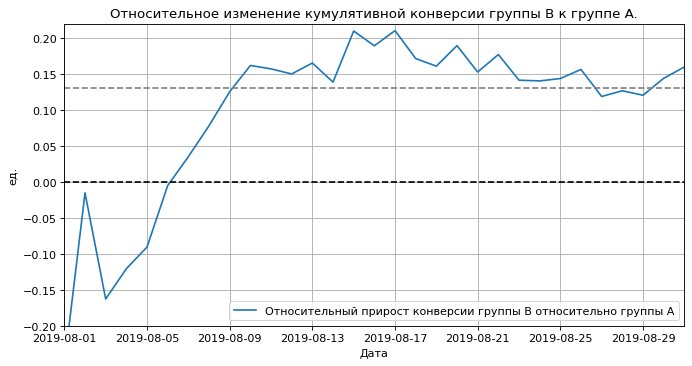

True

In [68]:
cum_con()

3. При этом по очищенным данным величина разницы даже выше 13% и составляет 17%.


4. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
5. При этом отношение среднего чека к групп В к А подвержено выбросам и по нему нельзя сделать выводы:

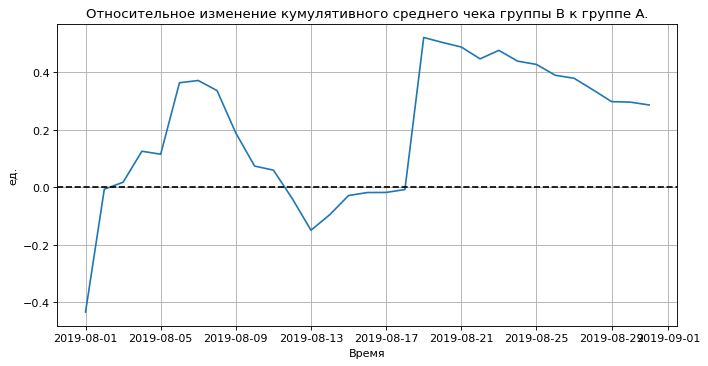

In [69]:
cum_avg_revenue_per_user()
None

6. Однако по очищенным данным видно, что средний чек уменьшился на 2%.

**Таким образом можно сказать, что:**
1. увеличение конверсии из визитов в визитов в заказы на 17.3% при неизменном среднем чеке является положительным исходом. Поэтому тест можно прекратить и остановиться на варианте В.
2. При этом по возможности стоит продолжить тест на ещё пару недель, чтобы посмотреть, сохранится ли тренд на сближение конверсии групп А и В. 


## 4 = Выводы.

**Качество и полнота входных данных:**

- датасеты содержат информацию о 18736 визитах из группы А и 18916 визитах из группы B, а также 468 заказов в группе А и 548 заказах в группе В. Этого, похоже, достаточно для проведения исследования.
- при этом из анализа удалили данные о 181 заказе от 58 пользователей, которые попали в группы A и В одновременно. Они были удалены из таблицы.
- имена в `hypothesis` и `visits` приведены к `camel_case`
- Пропусков нет ни в одном из датасетов.
- Проверяем типы данных - изменили тип со строковрого на дату в датасетах `visits` и `orders`.
- дубликатов в входных данных нет ни в одном из датасетов.

Итого: Данных достаточно и с ними можно работать дальше.



**Итоги А/В теста:** 


Были исследованы два параметра со следующими результатами - в группе В:

1. Есть статистически значимое различие по конверсии количества визитов в количество заказов между группами и по «сырым», и по данным после фильтрации аномалий. По очищенным данным конверсия увеличилась на 17.39%, что сущесвенно;
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.

**Таким образом можно сказать, что:**
1. увеличение конверсии из визитов в визитов в заказы на 17.39% при неизменном среднем чеке является положительным исходом. Поэтому тест можно прекратить и остановиться на варианте В.
2. При этом по возможности стоит продолжить тест на ещё пару недель, чтобы посмотреть, сохранится ли тренд на сближение конверсии групп А и В. 